analysis -> feat eng -> model -> web app

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
pd.set_option("display.max_columns", None)

In [ ]:
sns.set_style("whitegrid")

In [ ]:
df = pd.read_csv("german_credit_data.csv")

In [ ]:
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [ ]:
df["Age"].describe()

,Age
count,1000.000000
mean,35.546000
std,11.375469
min,19.000000
25%,27.000000
50%,33.000000
75%,42.000000
max,75.000000


In [ ]:
df["Risk"].value_counts()

,count
Risk,
good,700
bad,300


In [ ]:
df.shape

(1000, 11)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


In [ ]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,1000.0,NaN,NaN,NaN,499.5,288.819436,0.0,249.75,499.5,749.25,999.0
Age,1000.0,NaN,NaN,NaN,35.546,11.375469,19.0,27.0,33.0,42.0,75.0
Sex,1000,2,male,690,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Job,1000.0,NaN,NaN,NaN,1.904,0.653614,0.0,2.0,2.0,2.0,3.0
Housing,1000,3,own,713,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Saving accounts,817,4,little,603,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Checking account,606,3,little,274,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Credit amount,1000.0,NaN,NaN,NaN,3271.258,2822.736876,250.0,1365.5,2319.5,3972.25,18424.0
Duration,1000.0,NaN,NaN,NaN,20.903,12.058814,4.0,12.0,18.0,24.0,72.0
Purpose,1000,8,car,337,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df["Job"].unique()

array([2, 1, 3, 0])

In [ ]:
df.isna().sum()

,0
Unnamed: 0,0
Age,0
Sex,0
Job,0
Housing,0
Saving accounts,183
Checking account,394
Credit amount,0
Duration,0
Purpose,0


In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df = df.dropna().reset_index(drop=True)

In [ ]:
df

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
1,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
2,4,53,male,2,free,little,little,4870,24,car,bad
3,7,35,male,3,rent,little,moderate,6948,36,car,good
4,9,28,male,3,own,little,moderate,5234,30,car,bad
...,...,...,...,...,...,...,...,...,...,...,...
517,989,48,male,1,own,little,moderate,1743,24,radio/TV,good
518,993,30,male,3,own,little,little,3959,36,furniture/equipment,good
519,996,40,male,3,own,little,little,3857,30,car,good
520,998,23,male,2,free,little,little,1845,45,radio/TV,bad


In [ ]:
df.columns

Index(['Unnamed: 0', 'Age', 'Sex', 'Job', 'Housing', 'Saving accounts',
       'Checking account', 'Credit amount', 'Duration', 'Purpose', 'Risk'],
      dtype='object')

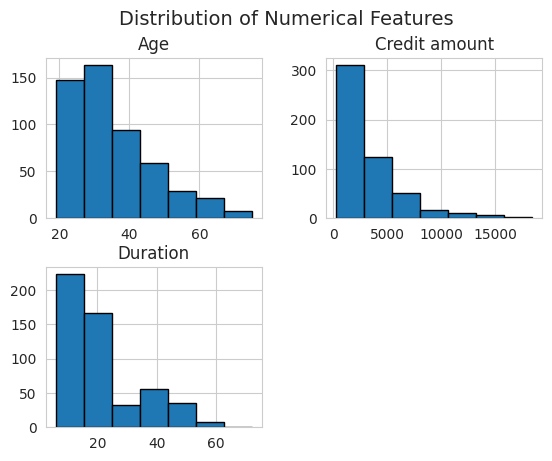

In [ ]:
# df.drop(columns= 'Unnamed: 0',implace=true )
df[["Age","Credit amount", "Duration"]].hist(bins=7, edgecolor= "black")
plt.suptitle("Distribution of Numerical Features", fontsize = 14)
plt.show()

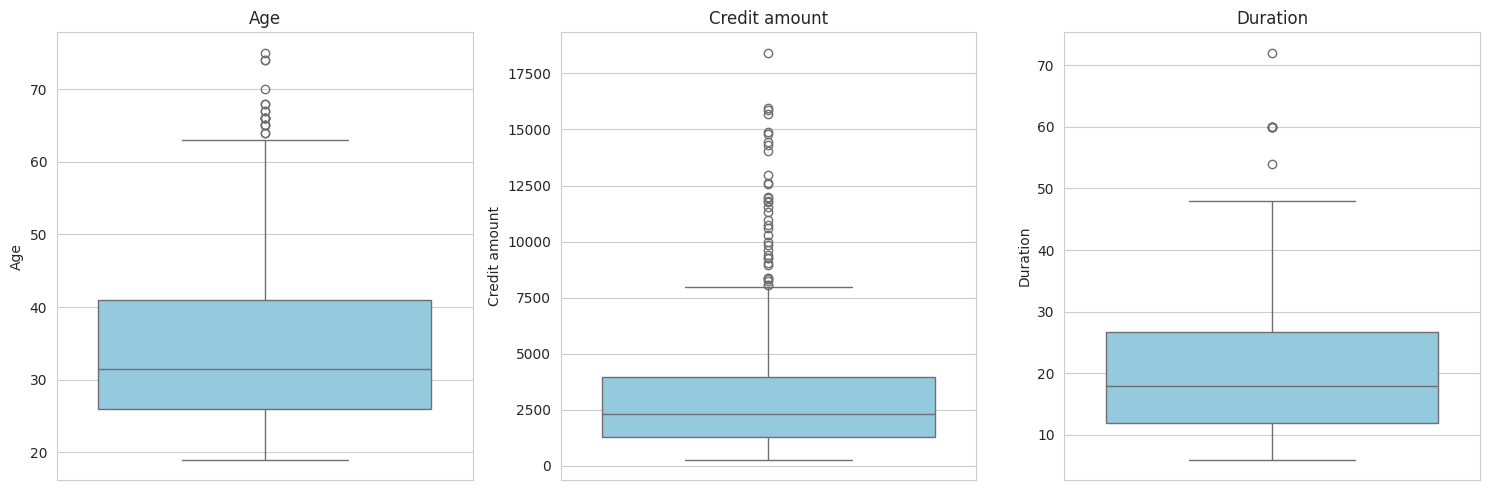

In [ ]:
plt.figure(figsize=(15, 5))
for i , col in enumerate(["Age","Credit amount","Duration"]):
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=df[col], color="skyblue")
    plt.title(col)

plt.tight_layout()
plt.show()

In [ ]:
df.query("Duration >= 60")

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
18,29,63,male,2,own,little,little,6836,60,business,bad
176,332,24,female,3,own,moderate,moderate,7408,60,car,bad
199,374,60,female,3,free,moderate,moderate,14782,60,vacation/others,bad
358,677,24,male,2,own,moderate,moderate,5595,72,radio/TV,bad
378,714,27,male,3,own,little,moderate,14027,60,car,bad
489,938,42,male,2,free,little,moderate,6288,60,education,bad
507,973,36,male,2,rent,little,little,7297,60,business,bad


In [ ]:
categorical_cols = ["Sex","Job","Housing","Saving accounts", "Checking account", "Purpose"]

/tmp/ipython-input-1164039085.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data= df, x = col, palette= "Set2", order = df[col].value_counts().index)
/tmp/ipython-input-1164039085.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data= df, x = col, palette= "Set2", order = df[col].value_counts().index)
/tmp/ipython-input-1164039085.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data= df, x = col, palette= "Set2", order = df[col].value_counts().index)
/tmp/ipython-input-1164039085.py:4: FutureWarning: 

Passing `palette` wi

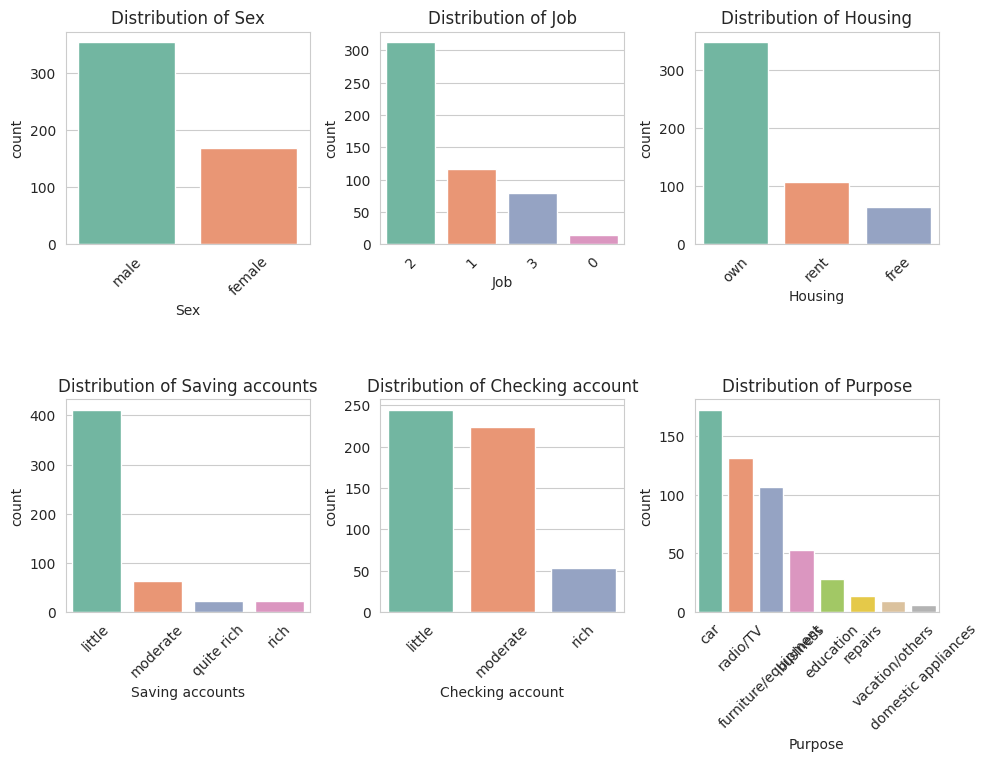

In [ ]:
plt.figure(figsize=(10,10))
for i, col in enumerate(categorical_cols):
  plt.subplot(3,3,i+1)
  sns.countplot(data= df, x = col, palette= "Set2", order = df[col].value_counts().index)
  plt.title(f"Distribution of {col}")
  plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
corr = df[["Age", "Job", "Credit amount", "Duration"]].corr()

In [ ]:
corr

,Age,Job,Credit amount,Duration
Age,1.000000,0.039771,0.082014,0.001549
Job,0.039771,1.000000,0.334721,0.200794
Credit amount,0.082014,0.334721,1.000000,0.613298
Duration,0.001549,0.200794,0.613298,1.000000


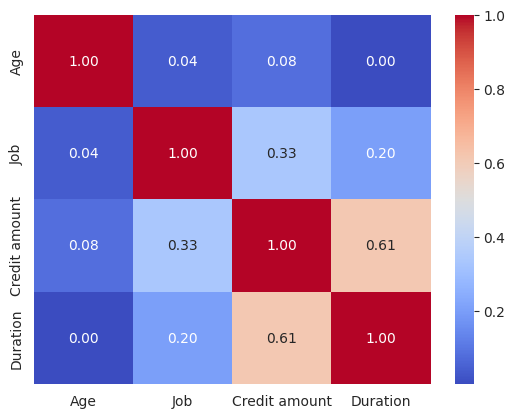

In [ ]:
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

In [ ]:
df.groupby("Job")["Credit amount"].mean()

,Credit amount
Job,
0,1767.857143
1,2250.715517
2,3129.130990
3,5648.784810


In [ ]:
df.groupby("Sex")["Credit amount"].mean()

,Credit amount
Sex,
female,2937.202381
male,3440.833333


In [ ]:
pd.pivot_table(df, values="Credit amount", index="Housing", columns = "Purpose")

Purpose,business,car,domestic appliances,education,furniture/equipment,radio/TV,repairs,vacation/others
Housing,,,,,,,,
free,4705.000000,5180.314286,NaN,5314.250000,4419.444444,2097.000000,1190.0,7842.666667
own,3725.973684,3120.485437,1333.5,2625.076923,3031.100000,2307.613861,2993.5,10321.833333
rent,6180.833333,3398.285714,NaN,2627.857143,2890.285714,2138.000000,2384.0,NaN


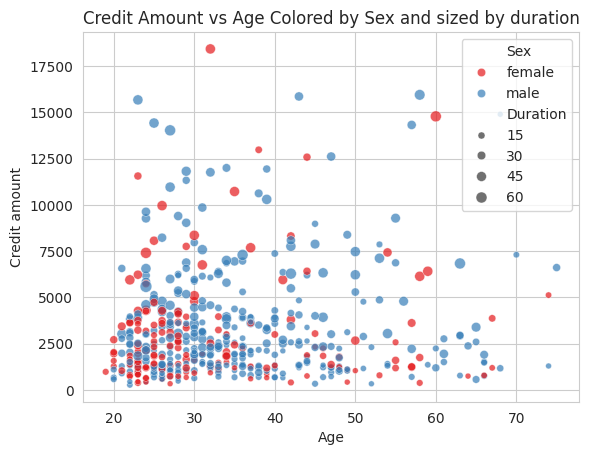

In [ ]:
sns.scatterplot(data = df, x= "Age", y= "Credit amount", hue= "Sex", size = "Duration", alpha = 0.7, palette="Set1")
plt.title("Credit Amount vs Age Colored by Sex and sized by duration")
plt.show()

/tmp/ipython-input-2798396807.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data= df, x= "Saving accounts", y="Credit amount", palette ="Pastel1")


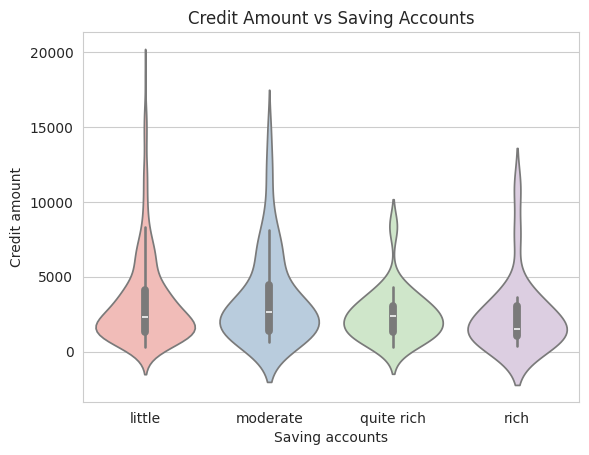

In [ ]:
sns.violinplot(data= df, x= "Saving accounts", y="Credit amount", palette ="Pastel1")
plt.title("Credit Amount vs Saving Accounts")
plt.show()

In [ ]:
df["Risk"].value_counts(normalize=True) * 100

,proportion
Risk,
good,55.747126
bad,44.252874


/tmp/ipython-input-2991790155.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Risk", y = col, palette="Pastel2")
/tmp/ipython-input-2991790155.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Risk", y = col, palette="Pastel2")
/tmp/ipython-input-2991790155.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Risk", y = col, palette="Pastel2")


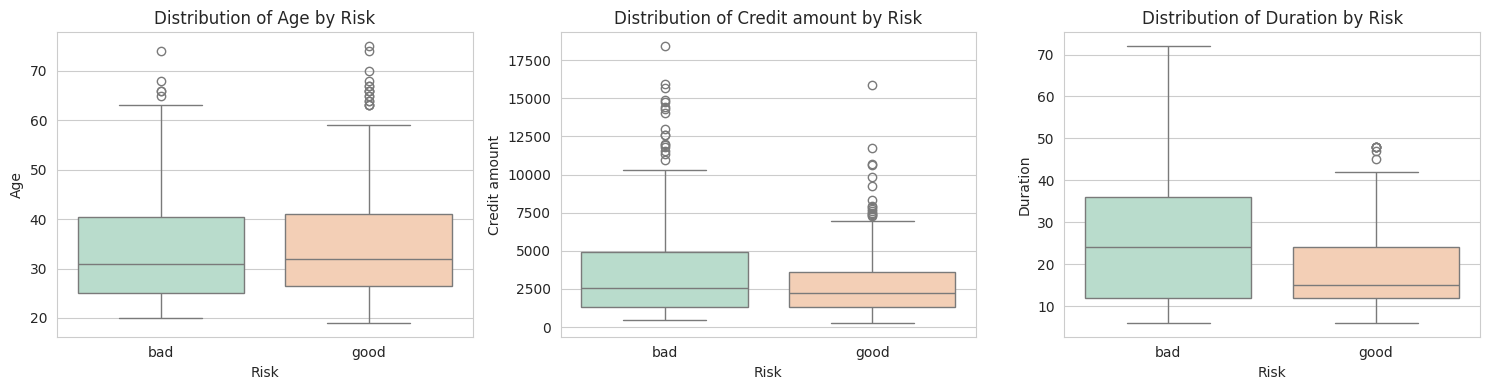

In [ ]:
plt.figure(figsize=(15,4))
for i, col in enumerate(["Age", "Credit amount", "Duration"]):
  plt.subplot(1,3,i+1)
  sns.boxplot(data=df, x="Risk", y = col, palette="Pastel2")
  plt.title(f"Distribution of {col} by Risk")

plt.tight_layout()
plt.show()

In [ ]:
df.groupby("Risk")[["Age", "Credit amount", "Duration"]].mean()

,Age,Credit amount,Duration
Risk,,,
bad,34.147186,3881.090909,25.445887
good,35.477663,2800.594502,18.079038


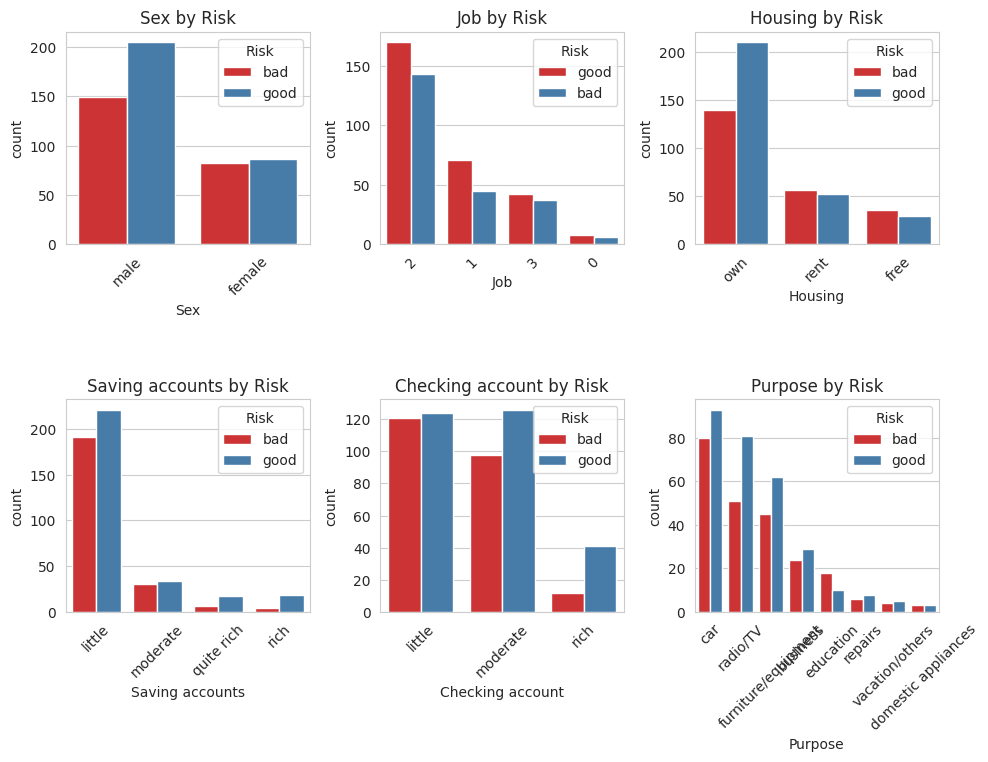

In [ ]:
plt.figure(figsize=(10,10))
for i, col in enumerate(categorical_cols):
  plt.subplot(3,3,i+1)
  sns.countplot(data=df, x=col, hue="Risk", palette="Set1", order= df[col].value_counts().index)
  plt.title(f"{col} by Risk")
  plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
df.columns

Index(['Unnamed: 0', 'Age', 'Sex', 'Job', 'Housing', 'Saving accounts',
       'Checking account', 'Credit amount', 'Duration', 'Purpose', 'Risk'],
      dtype='object')

In [ ]:
features = ["Age", "Sex", "Job", "Housing", "Saving accounts", "Checking account", "Credit amount", "Duration" ]

In [ ]:
target = "Risk"

In [ ]:
df_model = df[features + [target]].copy()

In [ ]:
df_model.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Risk
0,22,female,2,own,little,moderate,5951,48,bad
1,45,male,2,free,little,little,7882,42,good
2,53,male,2,free,little,little,4870,24,bad
3,35,male,3,rent,little,moderate,6948,36,good
4,28,male,3,own,little,moderate,5234,30,bad


In [ ]:
from sklearn.preprocessing import LabelEncoder
import joblib

In [ ]:
cat_cols = df_model.select_dtypes(include = "object").columns.drop("Risk")

In [ ]:
le_dict = {}

In [ ]:
cat_cols

Index(['Sex', 'Housing', 'Saving accounts', 'Checking account'], dtype='object')

In [ ]:
for col in cat_cols:
  le = LabelEncoder()
  df_model[col] = le.fit_transform(df_model[col])
  le_dict[col] = le
  joblib.dump(le, f"{col}_encoder.pkl")

In [ ]:
le_target = LabelEncoder()

In [ ]:
target

'Risk'

In [ ]:
df_model[target] = le_target.fit_transform(df_model[target])

In [ ]:
df_model[target].value_counts()

,count
Risk,
1,291
0,231


In [ ]:
joblib.dump(le_target, "target_encoder.pkl")

['target_encoder.pkl']

In [ ]:
df_model.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Risk
0,22,0,2,1,0,1,5951,48,0
1,45,1,2,0,0,0,7882,42,1
2,53,1,2,0,0,0,4870,24,0
3,35,1,3,2,0,1,6948,36,1
4,28,1,3,1,0,1,5234,30,0


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = df_model.drop(target, axis=1)

In [ ]:
y = df_model[target]

In [ ]:
df["Saving accounts"].unique()

array(['little', 'moderate', 'quite rich', 'rich'], dtype=object)

In [ ]:
df["Checking account"].unique()

array(['moderate', 'little', 'rich'], dtype=object)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

In [ ]:
X_train.shape

(417, 8)

In [ ]:
X_test.shape

(105, 8)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [ ]:
from sklearn.metrics import accuracy_score
def train_model(model, param_grid, X_train, y_train, X_test, y_test):
    grid = GridSearchCV(model, param_grid, cv=5, scoring="accuracy", n_jobs = 1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return best_model, acc, grid.best_params_
    print("Best Parameters:", grid.best_params_)


In [ ]:
dt = DecisionTreeClassifier(random_state = 1, class_weight = "balanced")
dt_param_grid = {
    "max_depth": [3,5,7,10,None],
    "min_samples_split": [2,5,10],
    "min_samples_leaf": [1,2,4]
}

In [ ]:
best_dt, acc_dt, params_dt = train_model(dt, dt_param_grid, X_train, y_train, X_test, y_test)

In [ ]:
print("Decision Tree Accuracy", acc_dt)

Decision Tree Accuracy 0.580952380952381


In [ ]:
print("Best parameters", params_dt)

Best parameters {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [ ]:
rf = RandomForestClassifier(random_state = 1, class_weight = "balanced")

In [ ]:
rf_param_grid = {
    "n_estimators": [100,200,],
    "max_depth" : [5,7,10,None],
    "min_samples_split": [2,5,10],
    "min_samples_leaf": [1,2,4]
}

In [ ]:
best_rf, acc_rf, params_rf = train_model(rf, rf_param_grid, X_train, y_train, X_test, y_test)

In [ ]:
print("Random Forest Accuracy", acc_rf)

Random Forest Accuracy 0.6190476190476191


In [ ]:
print("Best params", params_rf)

Best params {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


In [ ]:
et = ExtraTreesClassifier(random_state = 1, class_weight = "balanced", n_jobs =1)

In [ ]:
et_param_grid = {
    "n_estimators": [100,200,],
    "max_depth" : [5,7,10,None],
    "min_samples_split": [2,5,10],
    "min_samples_leaf": [1,2,4]
}

In [ ]:
best_et, acc_et, params_et = train_model(et, et_param_grid, X_train, y_train, X_test, y_test)

In [ ]:
print("Extra tress accuracy", acc_et)

Extra tress accuracy 0.6476190476190476


In [ ]:
print("Best params:", params_et)

Best params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


In [ ]:
xgb = XGBClassifier(random_state = 1, scale_pos_weight = (y_train ==0).sum() / (y_train == 1).sum(), use_label_encoder = False, eval_metric = "logloss"  )

In [ ]:
xgb_params_grid = {
    "n_estimators": [100,200],
    "max_depth": [3,5,7],
    "learning_rate": [0.01,0.1,0.2],
    "subsample" : [0.7,1],
    "colsample_bytree": [0.7,1]
}

In [ ]:
best_xg, acc_xgb, params_xgb = train_model(xgb, xgb_params_grid, X_train, y_train, X_test, y_test)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:34:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:34:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:34:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:34:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:34:23] WARNING: /w

In [ ]:
print("XGB accuracy", acc_xgb)

XGB accuracy 0.6666666666666666


In [ ]:
print("Best params", params_xgb)

Best params {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}


In [ ]:
best_et.predict(X_test)

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1])

In [ ]:
joblib.dump(best_et, "extra_tress_credit_model.pkl")

['extra_tress_credit_model.pkl']